In [5]:
from PIL import Image, ImageStat
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from scipy.ndimage.filters import gaussian_filter
from sklearn.cluster import MeanShift, KMeans, estimate_bandwidth
from skimage.metrics import mean_squared_error
import matplotlib.pyplot as plt
import glob 
import random
import numpy as np
import os
import re
import cv2
import argparse
import pandas as pd
import math
import torch  
import torch.nn.functional as F 

/var/folders/n2/h_p1g87j4fx1l3clf8fzzls80000gn/T/ipykernel_2905/3357147910.py:5: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [6]:
# 检查所有all文件 一共IMG_NUM = 474个图片文件 train:val:test 约为 8:4:3
# 但是多次运行中数据集的分割有细微差别（差1个） 所以对于每个只保留到全非0的列 之后全部舍去
# 以下数字是根据生成的表格手动确定的
# TRAIN_NUM = 252
# VAL_NUM = 126
TEST_NUM = 94

In [7]:
#  文件夹名称不同 内部文件名相同
res_file_dir = '../result_data/srcnn_results_10_001_mse_ep5/'

In [8]:
# test set for all folds

# # PSNR
# test_results_psnr_0 = pd.read_csv(res_file_dir + 'test_results_psnr_all_0.csv')
# test_results_psnr_1 = pd.read_csv(res_file_dir + 'test_results_psnr_all_1.csv')
# test_results_psnr_2 = pd.read_csv(res_file_dir + 'test_results_psnr_all_2.csv')
# test_results_psnr_3 = pd.read_csv(res_file_dir + 'test_results_psnr_all_3.csv')
# test_results_psnr_4 = pd.read_csv(res_file_dir + 'test_results_psnr_all_4.csv')

# SSIM
test_results_ssim_0 = pd.read_csv(res_file_dir + 'test_results_ssim_all_0.csv')
test_results_ssim_1 = pd.read_csv(res_file_dir + 'test_results_ssim_all_1.csv')
test_results_ssim_2 = pd.read_csv(res_file_dir + 'test_results_ssim_all_2.csv')
test_results_ssim_3 = pd.read_csv(res_file_dir + 'test_results_ssim_all_3.csv')
test_results_ssim_4 = pd.read_csv(res_file_dir + 'test_results_ssim_all_4.csv')

# SSSIM
test_results_sssim_0 = pd.read_csv(res_file_dir + 'test_results_sssim_all_0.csv')
test_results_sssim_1 = pd.read_csv(res_file_dir + 'test_results_sssim_all_1.csv')
test_results_sssim_2 = pd.read_csv(res_file_dir + 'test_results_sssim_all_2.csv')
test_results_sssim_3 = pd.read_csv(res_file_dir + 'test_results_sssim_all_3.csv')
test_results_sssim_4 = pd.read_csv(res_file_dir + 'test_results_sssim_all_4.csv') 

# # crop the data frames
# test_results_psnr_0 = test_results_psnr_0.iloc[:TEST_NUM, 1:]
# test_results_psnr_1 = test_results_psnr_1.iloc[:TEST_NUM, 1:]
# test_results_psnr_2 = test_results_psnr_2.iloc[:TEST_NUM, 1:]
# test_results_psnr_3 = test_results_psnr_3.iloc[:TEST_NUM, 1:]
# test_results_psnr_4 = test_results_psnr_4.iloc[:TEST_NUM, 1:]

test_results_ssim_0 = test_results_ssim_0.iloc[:TEST_NUM, 1:]
test_results_ssim_1 = test_results_ssim_1.iloc[:TEST_NUM, 1:]
test_results_ssim_2 = test_results_ssim_2.iloc[:TEST_NUM, 1:]
test_results_ssim_3 = test_results_ssim_3.iloc[:TEST_NUM, 1:]
test_results_ssim_4 = test_results_ssim_4.iloc[:TEST_NUM, 1:]

test_results_sssim_0 = test_results_sssim_0.iloc[:TEST_NUM, 1:]
test_results_sssim_1 = test_results_sssim_1.iloc[:TEST_NUM, 1:]
test_results_sssim_2 = test_results_sssim_2.iloc[:TEST_NUM, 1:]
test_results_sssim_3 = test_results_sssim_3.iloc[:TEST_NUM, 1:]
test_results_sssim_4 = test_results_sssim_4.iloc[:TEST_NUM, 1:]

### Visualize Test Set
### SSIM / SSSIM Comparison for all n-folds

(1.0, 5.0)

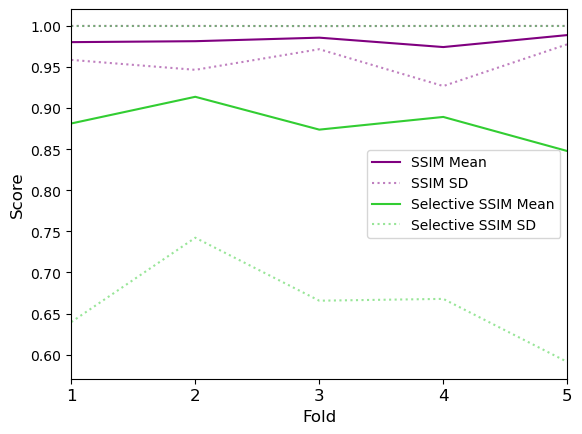

In [9]:
ssim_means_0 = test_results_ssim_0.mean()
ssim_stds_0 = test_results_ssim_0.std()
ssim_std_upper_0 = ssim_means_0 + ssim_stds_0
ssim_std_lower_0 = ssim_means_0 - ssim_stds_0
ssim_means_0 = ssim_means_0.mean()
ssim_stds_0 = ssim_stds_0.mean()
ssim_std_upper_0 = ssim_std_upper_0.mean()
ssim_std_lower_0 = ssim_std_lower_0.mean()

ssim_means_1 = test_results_ssim_1.mean()
ssim_stds_1 = test_results_ssim_1.std()
ssim_std_upper_1 = ssim_means_1 + ssim_stds_1
ssim_std_lower_1 = ssim_means_1 - ssim_stds_1
ssim_means_1 = ssim_means_1.mean()
ssim_stds_1 = ssim_stds_1.mean()
ssim_std_upper_1 = ssim_std_upper_1.mean()
ssim_std_lower_1 = ssim_std_lower_1.mean()

ssim_means_2 = test_results_ssim_2.mean()
ssim_stds_2 = test_results_ssim_2.std()
ssim_std_upper_2 = ssim_means_2 + ssim_stds_2
ssim_std_lower_2 = ssim_means_2 - ssim_stds_2
ssim_means_2 = ssim_means_2.mean()
ssim_stds_2 = ssim_stds_2.mean()
ssim_std_upper_2 = ssim_std_upper_2.mean()
ssim_std_lower_2 = ssim_std_lower_2.mean()

ssim_means_3 = test_results_ssim_3.mean()
ssim_stds_3 = test_results_ssim_3.std()
ssim_std_upper_3 = ssim_means_3 + ssim_stds_3
ssim_std_lower_3 = ssim_means_3 - ssim_stds_3
ssim_means_3 = ssim_means_3.mean()
ssim_stds_3 = ssim_stds_3.mean()
ssim_std_upper_3 = ssim_std_upper_3.mean()
ssim_std_lower_3 = ssim_std_lower_3.mean()

ssim_means_4 = test_results_ssim_4.mean()
ssim_stds_4 = test_results_ssim_4.std()
ssim_std_upper_4 = ssim_means_4 + ssim_stds_4
ssim_std_lower_4 = ssim_means_4 - ssim_stds_4
ssim_means_4 = ssim_means_4.mean()
ssim_stds_4 = ssim_stds_4.mean()
ssim_std_upper_4 = ssim_std_upper_4.mean()
ssim_std_lower_4 = ssim_std_lower_4.mean()

ssim_means = [ssim_means_0, ssim_means_1, ssim_means_2, ssim_means_3, ssim_means_4]
ssim_stds = [ssim_stds_0, ssim_stds_1, ssim_stds_2, ssim_stds_3, ssim_stds_4]
ssim_std_upper = [ssim_std_upper_0, ssim_std_upper_1, ssim_std_upper_2, ssim_std_upper_3, ssim_std_upper_4]
ssim_std_lower = [ssim_std_lower_0, ssim_std_lower_1, ssim_std_lower_2, ssim_std_lower_3, ssim_std_lower_4]

for i in range(len(ssim_std_upper)):
    if ssim_std_upper[i] > 1:
        ssim_std_upper[i] = 1

sssim_means_0 = test_results_sssim_0.mean()
sssim_stds_0 = test_results_sssim_0.std()
sssim_std_upper_0 = sssim_means_0 + sssim_stds_0
sssim_std_lower_0 = sssim_means_0 - sssim_stds_0
sssim_means_0 = sssim_means_0.mean()
sssim_stds_0 = sssim_stds_0.mean()
sssim_std_upper_0 = sssim_std_upper_0.mean()
sssim_std_lower_0 = sssim_std_lower_0.mean()

sssim_means_1 = test_results_sssim_1.mean()
sssim_stds_1 = test_results_sssim_1.std()
sssim_std_upper_1 = sssim_means_1 + sssim_stds_1
sssim_std_lower_1 = sssim_means_1 - sssim_stds_1
sssim_means_1 = sssim_means_1.mean()
sssim_stds_1 = sssim_stds_1.mean()
sssim_std_upper_1 = sssim_std_upper_1.mean()
sssim_std_lower_1 = sssim_std_lower_1.mean()

sssim_means_2 = test_results_sssim_2.mean()
sssim_stds_2 = test_results_sssim_2.std()
sssim_std_upper_2 = sssim_means_2 + sssim_stds_2
sssim_std_lower_2 = sssim_means_2 - sssim_stds_2
sssim_means_2 = sssim_means_2.mean()
sssim_stds_2 = sssim_stds_2.mean()
sssim_std_upper_2 = sssim_std_upper_2.mean()
sssim_std_lower_2 = sssim_std_lower_2.mean()

sssim_means_3 = test_results_sssim_3.mean()
sssim_stds_3 = test_results_sssim_3.std()
sssim_std_upper_3 = sssim_means_3 + sssim_stds_3
sssim_std_lower_3 = sssim_means_3 - sssim_stds_3
sssim_means_3 = sssim_means_3.mean()
sssim_stds_3 = sssim_stds_3.mean()
sssim_std_upper_3 = sssim_std_upper_3.mean()
sssim_std_lower_3 = sssim_std_lower_3.mean()

sssim_means_4 = test_results_sssim_4.mean()
sssim_stds_4 = test_results_sssim_4.std()
sssim_std_upper_4 = sssim_means_4 + sssim_stds_4
sssim_std_lower_4 = sssim_means_4 - sssim_stds_4
sssim_means_4 = sssim_means_4.mean()
sssim_stds_4 = sssim_stds_4.mean()
sssim_std_upper_4 = sssim_std_upper_4.mean()
sssim_std_lower_4 = sssim_std_lower_4.mean()

sssim_means = [sssim_means_0, sssim_means_1, sssim_means_2, sssim_means_3, sssim_means_4]
sssim_stds = [sssim_stds_0, sssim_stds_1, sssim_stds_2, sssim_stds_3, sssim_stds_4]
sssim_std_upper = [sssim_std_upper_0, sssim_std_upper_1, sssim_std_upper_2, sssim_std_upper_3, sssim_std_upper_4]
sssim_std_lower = [sssim_std_lower_0, sssim_std_lower_1, sssim_std_lower_2, sssim_std_lower_3, sssim_std_lower_4]

for i in range(len(sssim_std_upper)):
    if sssim_std_upper[i] > 1:
        sssim_std_upper[i] = 1



n_folds = np.linspace(1,5,5)

plt.figure()

plt.plot(n_folds, ssim_means, color='purple', label='SSIM Mean')
plt.plot(n_folds, ssim_std_upper, color='purple', label='SSIM SD', linestyle='dotted', alpha=0.5)
plt.plot(n_folds, ssim_std_lower, color='purple', linestyle='dotted', alpha=0.5)

plt.plot(n_folds, sssim_means, color='limegreen', label='Selective SSIM Mean')
plt.plot(n_folds, sssim_std_upper, color='limegreen', label='Selective SSIM SD', linestyle='dotted', alpha=0.5)
plt.plot(n_folds, sssim_std_lower, color='limegreen', linestyle='dotted', alpha=0.5)


plt.legend(fontsize=10)
plt.xlabel('Fold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks([1,2,3,4,5],["1","2","3","4","5"],fontsize=12)
# plt.yticks([0.6,0.7,0.8,0.9,1.0],["0.6","0.7","0.8","0.9","1.0"],fontsize=12)
plt.xlim(xmin=1, xmax=5)
# plt.ylim(ymin=0.6, ymax=1.02)
# plt.savefig(res_file_dir + 'ssim_test_mean_all_folds.png')

In [10]:
print(ssim_means)
print(ssim_stds)

[0.9802595385422942, 0.9814120613514108, 0.9857114077882564, 0.9742745968466955, 0.9888541129886681]
[0.02161943884160299, 0.0348422652965788, 0.014061152419378902, 0.04745300309922711, 0.01123145628870928]


In [11]:
print(sssim_means)
print(sssim_stds)

[0.8812912543773228, 0.9137457166897489, 0.8737846150043164, 0.8892329049871323, 0.8477424114995391]
[0.24168529389685658, 0.17150388477462422, 0.2081888292861496, 0.2214211395350131, 0.25665742776081285]
